### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
import h5py
import keras
import numpy as np
from tensorflow.keras.utils import Sequence
from matplotlib.colors import LogNorm

2022-09-21 20:10:42.226341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 20:10:42.226379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-09-21 20:10:44.615762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-21 20:10:44.615804: W tensorflow/

### load data 

In [2]:
f3 = h5py.File("../../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
f2 = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
f = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n139306.hdf5","r")

In [3]:
x_train = f3.get('X_jets')
y_train = f3.get('y')

x_val = f2.get('X')
y_val = f2.get('y')

x_test = f2.get('X')
y_test = f2.get('y')

In [5]:
x_val_ones = x_val[y_val[()]==1]
x_val = x_val[y_val[()]==0]

div1 = np.max(x_val, axis=(1,2)).reshape((x_val.shape[0],1,1,3))
div1[div1 == 0] = 1
x_val = x_val / div1
div2 = np.max(x_val_ones, axis=(1,2)).reshape((x_val_ones.shape[0],1,1,3))
div2[div2 == 0] = 1
x_val_ones = x_val_ones / div2

x_test = x_val
x_test_ones = x_val_ones

### resize and safe to new file

In [10]:
def crop(x, channel, crop_fraction):
    return f.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],125,125,1), crop_fraction)

In [11]:
def crop_and_resize(x, channel, scale, crop_fraction=0.8,meth="bilinear"):
    cropped = tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],125,125,1), crop_fraction)
    return tf.image.resize(cropped, (scale,scale), method=meth).numpy()

In [12]:
def simple_resize(x, channel, scale, meth="bilinear"):
    return tf.image.resize(x[:,:,:,channel].reshape((x.shape[0],125,125,1)), (scale,scale), method=meth).numpy()

In [ ]:
batch_size = 20
num_batches = x_train.shape[0]//batch_size

events = num_batches*batch_size
fnew = h5py.File("QG_train_normalized", "w")
dsetx = fnew.create_dataset("X", (events,125,125,3), dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')
 


for i in range(int(num_batches)):
    y = y_train[i * batch_size: (i + 1) * batch_size]
    x = x_train[i * batch_size: (i + 1) * batch_size]

    div1 = np.max(x, axis=(1,2)).reshape((x.shape[0],1,1,3))
    div1[div1 == 0] = 1
    x = x / div1

    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x
    print("batch ",i,"/",num_batches, end="\r")
    
fnew.close()

### verify scaling

In [4]:
test = h5py.File("small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_s[y_s[:]==0],0),norm=LogNorm(), cmap='binary')
axs[0].title.set_text('Gluon')

axs[1].imshow(np.average(x_s[y_s[:]==1],0),norm=LogNorm(), cmap='binary')
axs[1].title.set_text('Quark')

fig.tight_layout()

test.close()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'small_quark_gluon_12', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

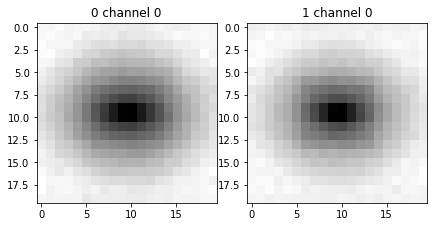

In [4]:
test = h5py.File("small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_s[y_s[:]==0],0),norm=LogNorm(), cmap='binary')
axs[0].title.set_text('0 channel 0')

axs[1].imshow(np.average(x_s[y_s[:]==1],0),norm=LogNorm(), cmap='binary')
axs[1].title.set_text('1 channel 0')

fig.tight_layout()

test.close()

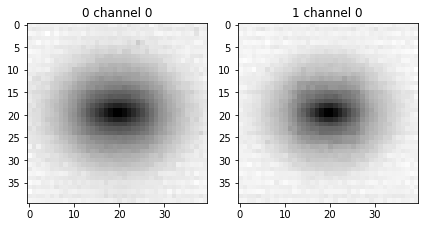

In [3]:
test = h5py.File("small_quark_gluon_candr","r")

x_s = test.get('X')
y_s = test.get('y')

fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_s[y_s[:]==0],0),norm=LogNorm(), cmap='binary')
axs[0].title.set_text('0 channel 0')

axs[1].imshow(np.average(x_s[y_s[:]==1],0),norm=LogNorm(), cmap='binary')
axs[1].title.set_text('1 channel 0')

fig.tight_layout()

test.close()

In [ ]:
test = h5py.File("small_quark_gluon_40L","r")

x_s = test.get('X')
y_s = test.get('y')

fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_s[y_s[:]==0],0),norm=LogNorm(), cmap='binary')
axs[0].title.set_text('0 channel 0')

axs[1].imshow(np.average(x_s[y_s[:]==1],0),norm=LogNorm(), cmap='binary')
axs[1].title.set_text('1 channel 0')

fig.tight_layout()

test.close()

In [2]:
test = h5py.File("small_quark_gluon_40L","r")

x_s = test.get('X')
y_s = test.get('y')

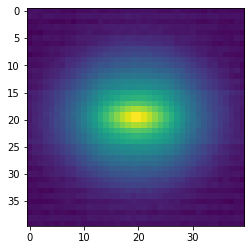

In [11]:
plt.imshow(np.average(x_s[:][y_s[:]==0], 0),norm=LogNorm())

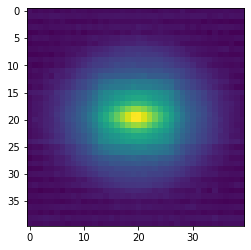

In [12]:
plt.imshow(np.average(x_s[:][y_s[:]==1], 0),norm=LogNorm())